# Training machine learning models 

## <a id='toc1_'></a>[Authors](#toc0_)
* **Alireza Arbabi**
* **Hadi Babalou**
* **Ali Padyav**
* **Kasra Hajiheidari**

## <a id='toc3_'></a>[Setting Up the Environment](#toc0_)

In [313]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import keras_tuner as kt
import ast
import numpy as np

This is the preprocessed dataset from phase 1.

In [314]:
data = pd.read_csv('dataset.csv')
data.head(5)

,track_name,album_name,artists,explicit,key,mode,time_signature,danceability,energy,loudness,...,week_of_year,day,day_of_week,day_of_year,duration_mins,duration_ms,artist_count,genre_count,track_genre,popularity
0,Ode To The Mets,The New Abnormal,['The Strokes'],False,1,0,4.0,0.4280,0.617,-5.424,...,15,10,Friday,101,5.863117,351787,1,2,"['alt-rock', 'garage']",67
1,Glaciers,Bloom,['Lights & Motion'],False,7,1,4.0,0.0789,0.160,-18.144,...,5,2,Friday,33,2.939550,176373,1,1,['ambient'],49
2,Uber Pussy,Pink Season,['Pink Guy'],True,7,1,4.0,0.8700,0.597,-6.320,...,1,4,Wednesday,4,1.956017,117361,1,1,['comedy'],39
3,2002,Speak Your Mind (Deluxe),['Anne-Marie'],False,1,0,4.0,0.6970,0.683,-2.881,...,17,27,Friday,117,3.116450,186987,1,3,"['dance', 'house', 'pop']",82
4,Monsters You Made (feat. Chris Martin),Twice As Tall,"['Burna Boy', 'Chris Martin']",True,7,0,4.0,0.6710,0.646,-7.513,...,33,13,Thursday,226,3.625683,217541,2,1,['dancehall'],45


In [315]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        4724 non-null   object 
 1   album_name        4724 non-null   object 
 2   artists           4724 non-null   object 
 3   explicit          4724 non-null   bool   
 4   key               4724 non-null   int64  
 5   mode              4724 non-null   int64  
 6   time_signature    4724 non-null   float64
 7   danceability      4724 non-null   float64
 8   energy            4724 non-null   float64
 9   loudness          4724 non-null   float64
 10  speechiness       4724 non-null   float64
 11  acousticness      4724 non-null   float64
 12  instrumentalness  4724 non-null   float64
 13  liveness          4724 non-null   float64
 14  valence           4724 non-null   float64
 15  tempo             4724 non-null   float64
 16  track_id          4724 non-null   object 


Remove ID columns because they are not useful for the model.

In [316]:
data = data.drop(['track_id', 'album_id', 'artist_ids'], axis=1)

In [317]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object
release_date: object
day_of_week: object
track_genre: object


As we extracted the date information, we can remove the original date columns.

In [318]:
data = data.drop(['release_date'], axis=1)

In [319]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object
day_of_week: object
track_genre: object


In [320]:
data['track_genre'] = data['track_genre'].apply(lambda x: ast.literal_eval(x))
data['artists'] = data['artists'].apply(lambda x: ast.literal_eval(x))

In [321]:
genres = set()
for genre_list in data['track_genre']:
    for genre in genre_list:
        genres.add(genre)
print(f'Unique genres: {len(genres)}')

Unique genres: 111


In [322]:
genre_counts = {}
for genre_list in data['track_genre']:
    for genre in genre_list:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1
i = 0
for genre, count in genre_counts.items():
    if(count > 5):
        i += 1
print(f'Genres with more than 20 tracks: {i}')

Genres with more than 20 tracks: 104


In [323]:
mlb = MultiLabelBinarizer()

one_hot_genres = mlb.fit_transform(data['track_genre'])
one_hot_df = pd.DataFrame(one_hot_genres, columns=mlb.classes_)
data = pd.concat([data, one_hot_df], axis=1)
data = data.drop(columns=['track_genre'])

In [324]:
data['day_of_week'] = data['day_of_week'].astype(pd.StringDtype())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Columns: 142 entries, track_name to world-music
dtypes: bool(1), float64(11), int32(111), int64(15), object(3), string(1)
memory usage: 3.1+ MB


In [325]:
onehotencoder = OneHotEncoder()
day_of_week_encoded = onehotencoder.fit_transform(data[['day_of_week']]).toarray()
day_of_week_encoded_df = pd.DataFrame(day_of_week_encoded, columns=onehotencoder.get_feature_names_out(['day_of_week']))
data = pd.concat([data, day_of_week_encoded_df], axis=1)
data.drop(columns=['day_of_week'], inplace=True)

In [326]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object


In [327]:
data = data.drop(columns=['track_name', 'album_name', 'artists'])

In [328]:
X = data.drop(columns=['popularity'])
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = data['popularity']

### Part 3: Dimensionality Reduction

**Principal Component Analysis (PCA)**

In [329]:
pca = PCA(n_components=0.9, random_state=31)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i}' for i in range(1, X_reduced.shape[1] + 1)])

# print(selected_columns)
print("Number of columns after PCA reduction:", X_reduced_df.columns.size)
print("Number of columns in the origianl Dataset:", X.columns.size)
print("Reduction Ratio", X_reduced_df.columns.size / X.columns.size)
print("Explained variance after reduction", np.cumsum(pca.explained_variance_ratio_)[-1])

Number of columns after PCA reduction: 104
Number of columns in the origianl Dataset: 144
Reduction Ratio 0.7222222222222222
Explained variance after reduction 0.9020223786319813


In [330]:
print("Correspondnig variances of each feature with the first PCA component:")
selected_columns = X.columns[pca.components_[0].argsort()[::-1]]
for col in selected_columns:
    print(f"    - {col}: {pca.components_[0][X.columns.get_loc(col)]}")

Correspondnig variances of each feature with the first PCA component:
    - day_of_year: 0.31008103629520534
    - month: 0.302346637573696
    - year: 0.2904356199621295
    - quarter: 0.2899397195271309
    - decade: 0.28312170522114727
    - loudness: 0.2521783134348245
    - day_of_week_Friday: 0.19524542327175873
    - day: 0.1837186676442142
    - week_of_year: 0.18346299687566903
    - energy: 0.17965672990920514
    - genre_count: 0.1447388386252877
    - house: 0.13801926842073442
    - danceability: 0.12351131597472685
    - electro: 0.117393829907801
    - edm: 0.11728640262037948
    - explicit: 0.11570427796856288
    - reggaeton: 0.09119621204785922
    - artist_count: 0.09034304767523733
    - latino: 0.08838480628331571
    - progressive-house: 0.08521638739618606
    - speechiness: 0.08312672558739712
    - reggae: 0.07976567391028785
    - dance: 0.07843266864107536
    - emo: 0.07540842681902506
    - dubstep: 0.07399467895779492
    - dub: 0.067208062500198
    - te

In [331]:
categorical_features = data.select_dtypes(exclude=['int', 'float']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

X_processed = preprocessor.fit_transform(X)

In [332]:
print(categorical_features)

Index(['explicit'], dtype='object')


### Train and Test Data

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3779, 146), (945, 146), (3779,), (945,))

In [334]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

In [335]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

C:\Users\apady\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [336]:
def fit_and_predict(model, X_train, y_train, X_test, y_test, epochs=20, validation_split=0.2, batch_size=10):
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size)
    y_pred = model.predict(X_test)

    return history, y_pred

In [337]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    history, y_pred = fit_and_predict(model, X_train, y_train, X_test, y_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title('True vs Predicted Popularity')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1001.0464 - mean_absolute_error: 24.1463 - val_loss: 142.3392 - val_mean_absolute_error: 9.4494
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 169.7509 - mean_absolute_error: 10.1188 - val_loss: 117.7818 - val_mean_absolute_error: 8.5531
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 140.3780 - mean_absolute_error: 9.1656 - val_loss: 130.4111 - val_mean_absolute_error: 8.8399
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 132.1357 - mean_absolute_error: 8.8760 - val_loss: 110.8521 - val_mean_absolute_error: 7.9985
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121.8804 - mean_absolute_error: 8.4380 - val_loss: 125.3100 - val_mean_absolute_error: 8.4842
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 116.7622 - mean_absolute_error: 8.1783 - val_loss: 117.5449 - val_mean_absolute_error: 8.1650
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 110.0022 - me

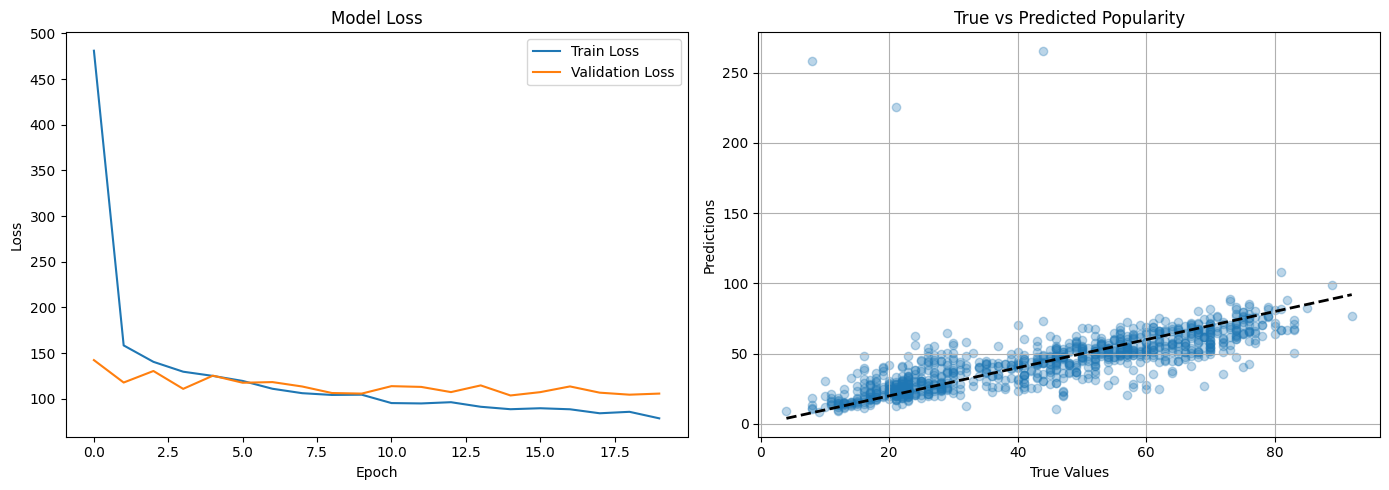

In [338]:
evaluate_model(model, X_train, y_train, X_test, y_test)